In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
import tensorflow as tf
from focal_loss import BinaryFocalLoss
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
#from imblearn.over_sampling import RandomOverSampler
from keras import regularizers
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from keras.utils.generic_utils import get_custom_objects



def binary_focal_loss(gamma=5, alpha=0.3):
    """
    Binary form of focal loss.
    適用於二分類問題的focal loss
    
    focal_loss(p_t) = -alpha_t * (1 - p_t)**gamma * log(p_t)
        where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    alpha = tf.constant(alpha, dtype=tf.float32)
    gamma = tf.constant(gamma, dtype=tf.float32)
    
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        y_true shape need be (None,1)
        y_pred need be compute after sigmoid
        """
        
        y_true = tf.cast(y_true, tf.float32)
        
        alpha_t = y_true*alpha + (K.ones_like(y_true)-y_true)*(1-alpha)
    
        p_t = y_true*y_pred + (K.ones_like(y_true)-y_true)*(K.ones_like(y_true)-y_pred) + K.epsilon()
        focal_loss = - alpha_t * K.pow((K.ones_like(y_true)-p_t),gamma) * K.log(p_t)
        
        return K.mean(focal_loss)
    return binary_focal_loss_fixed

get_custom_objects().update({'focal_loss':binary_focal_loss()})


#st = RandomOverSampler(random_state=1)
sc = StandardScaler()
    
df = pd.read_csv('./all_pre_model_2.csv',header=0)

df = df.drop(['離職日','外語專長種類數','第二個月忘刷卡次數','第三個月病假時數','體育專長種類數'
              ,'個人專長種類數','第三個月曠職時數','第二個月遺失卡次數'
            ,'第三個月未帶卡次數','第三個月遺失卡次數','第二個月遲到次數','第二個月未帶卡次數'
            ,'第三個月遲到次數'],axis=1)

cols = ['年資','是否離職','年齡','姓別代號','台成清交(最高)','理工科系(最高)','台成清交(次高)',
        '理工科系(次高)','婚姻代號','撫養人數','第三個月事假時數',
        '第三個月特休時數','第三個月忘刷卡次數','第二個月事假時數','第二個月病假時數','第二個月曠職時數',
        '第二個月特休時數','近一年考績']




#x = df.drop(['是否離職'],axis = 1).values
#y = df['是否離職'].values



df2 = []
cv_accuracies = []
steps = []

#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
#windows = 50000
#steps = 1000
#data = np.arange(len(df))
#print(data)

'''
def rolling(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

a = rolling(data,windows)
print(a.shape)
'''
#scores_roc = []
#scores_accuracy = []
m = 0

df['進企業日'] = (df['進企業日'] + 19110000)
temp = []
count = 0
day = df['進企業日']

for i in range(0,len(day)):
    aaa = str(day.iloc[i])
    string = aaa
    temp.append(string[4:6])
    print(temp)  

#print(len(temp))
for j in range(0,len(temp)-1,1):
    
    if (temp[j] == temp[j+1]):
        count = count + 1
    else:
        steps.append(count)
        count = 0
        #print(steps)
        #break
print(steps)


clf = Sequential()
clf.add(Dense(48, input_dim=17,kernel_regularizer=regularizers.l1_l2(l1=0.002,l2=0.002)))
clf.add(Activation('relu'))
clf.add(Dropout(0.3))
clf.add(Dense(24,kernel_regularizer=regularizers.l1_l2(l1=0.002,l2=0.002)))
clf.add(Activation('relu'))
clf.add(Dropout(0.3))
clf.add(Dense(1))
clf.add(Activation('sigmoid'))
clf.compile(optimizer='adam',loss=['focal_loss'],metrics=['accuracy'])

 

step = 0    
q = steps[0]
p = -1
z = 0
w = 7
sum_p = []
sum_ten = 0
temp1 = []
year = 5

for v in range(0,year,1):
    temp1.append(steps[v])
    sum_ten = sum(temp1)
#print(sum_ten)

for x in range(0,1,1): #10 years
    #print(steps[x])
    for o in range(p+1,sum_ten+1,1):
       #print((p+1,q+1))
       df2.append(df.iloc[o,:])
       #print(p+o)
       m = m + 1
    
       if m == (sum_ten - p):
            #print(1111)     
        
            test_1=pd.DataFrame(columns=cols,data=df2)
            #print(test_1.shape)
            
            x = test_1.drop(['是否離職'],axis = 1).values
            
            y = test_1['是否離職'].values
            
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
            '''
            x = test_1[cols]
            x = x.drop(['是否離職'],axis=1)
            x_train_pos_data = x.iloc[:int(len(x) * 0.7)].copy()   
            x_train_pos_data = x_train_pos_data.values
            x_test_pos_data = x.iloc[int(len(x) * 0.7):].copy()
            x_test_pos_data = x_test_pos_data.values
            
            
            y = test_1['是否離職']
            y_train_pos_data = y.iloc[:int(len(y) * 0.7)].copy()    
            y_train_pos_data = y_train_pos_data.values
            y_test_pos_data = y.iloc[int(len(x) * 0.7):].copy()  
            y_test_pos_data = y_test_pos_data.values
            '''
            #train_resample,train_resample_target = st.fit_sample(X_train,y_train)
           
            X_train = sc.fit_transform(X_train)
            X_test = sc.fit_transform(X_test)

            
            #clf.summary()
            #clf.compile(optimizer='adam',loss=[binary_focal_loss(alpha=.25, gamma=2)],metrics=['accuracy'])
            history = clf.fit(X_train, y_train, epochs = 10,verbose=0)            
            cost, accuracy = clf.evaluate(X_test, y_test, batch_size=y_test.shape[0], verbose=False)
            #y_pred = clf.predict_classes(X_test)
            cv_accuracies.append(accuracy)
            print('test cost:', cost, 'test accuracy:', accuracy)
            m = 0 


q = sum_ten + steps[year]

for x in range(year,len(steps)+1,1): #every 1 year
    #print(steps[x])
    for o in range(sum_ten+1,q+1,1):
       #print((p+1,q+1))
       df2.append(df.iloc[o,:])
       #print(p+o)
       m = m + 1
    
       if m == (q - sum_ten):
            #print(1111)     
        
            test_1=pd.DataFrame(columns=cols,data=df2)
            #print(test_1.shape)
            
            x = test_1.drop(['是否離職'],axis = 1).values
            
            y = test_1['是否離職'].values
            
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
            '''
            x = test_1[cols]
            x = x.drop(['是否離職'],axis=1)
            x_train_pos_data = x.iloc[:int(len(x) * 0.7)].copy()   
            x_train_pos_data = x_train_pos_data.values
            x_test_pos_data = x.iloc[int(len(x) * 0.7):].copy()
            x_test_pos_data = x_test_pos_data.values
            
            
            y = test_1['是否離職']
            y_train_pos_data = y.iloc[:int(len(y) * 0.7)].copy()    
            y_train_pos_data = y_train_pos_data.values
            y_test_pos_data = y.iloc[int(len(x) * 0.7):].copy()  
            y_test_pos_data = y_test_pos_data.values
            '''
            #train_resample,train_resample_target = st.fit_sample(X_train,y_train)
           
            X_train = sc.fit_transform(X_train)
            X_test = sc.fit_transform(X_test)

            
            #clf.summary()
            #clf.compile(optimizer='adam',loss=[binary_focal_loss(alpha=.25, gamma=2)],metrics=['accuracy'])
            history = clf.fit(X_train, y_train, epochs = 10,verbose=0)           
            cost, accuracy = clf.evaluate(X_test, y_test, batch_size=y_test.shape[0], verbose=False)
            #y_pred = clf.predict_classes(X_test)
            cv_accuracies.append(accuracy)
            print('test cost:', cost, 'test accuracy:', accuracy)
            #step = steps
            #print(step)
            m = 0 
            #if p == -1:
                
                #p = p + steps[z] + 1
            #else:
            #sum_ten = sum_ten + steps[z]
            
            if w != 18:
                for z in range(0,w,1):
                    sum_p.append(steps[z])
                    #print(sum_p)
                    q = sum(sum_p)
                                    
            sum_p = []
            #print(q)
            
            if w != 18:
                w = w + 1
                
            #print(w)
                #z = z + 1
            
            #for k in range(steps+step+1,len(temp)-1,1):
        
             #   if (temp[k] == temp[k+1]):
            
              #      count = count + 1
            
               # else:
                 #   step = steps + step  
                #    steps = count
                 #   count = 0
                    #print(steps,step)            
                 #   continue 
          
            
            


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



test cost: 0.4030808210372925 test accuracy: 0.6929134130477905
test cost: 0.1734163910150528 test accuracy: 0.6232876777648926
test cost: 0.048711150884628296 test accuracy: 0.6612021923065186
test cost: 0.019516998901963234 test accuracy: 0.6332046389579773
test cost: 0.011109324172139168 test accuracy: 0.65625
test cost: 0.009701880626380444 test accuracy: 0.6607539057731628
test cost: 0.009241646155714989 test accuracy: 0.6774193644523621
test cost: 0.009623861871659756 test accuracy: 0.6356821656227112
test cost: 0.0095414062961936 test accuracy: 0.648101270198822
test cost: 0.009723477065563202 test accuracy: 0.6300326585769653
test cost: 0.009438990615308285 test accuracy: 0.6586715579032898
test cost: 0.009598419070243835 test accuracy: 0.6398104429244995
test cost: 0.00969719048589468 test accuracy: 0.626719057559967
test cost: 0.009589399211108685 test accuracy: 0.6435366272926331
test cost: 0.00962976086884737 test accuracy: 0.63818359375
test cost: 0.009640882723033428 test

test cost: 0.009931174106895924 test accuracy: 0.5915994048118591
test cost: 0.009915836155414581 test accuracy: 0.5913004875183105
test cost: 0.00991771835833788 test accuracy: 0.5931364893913269
test cost: 0.009906251914799213 test accuracy: 0.5964243412017822
test cost: 0.009912550449371338 test accuracy: 0.5947169065475464
test cost: 0.009917010553181171 test accuracy: 0.5934059023857117
test cost: 0.009925025515258312 test accuracy: 0.5896567702293396
test cost: 0.009921845048666 test accuracy: 0.5937944650650024
test cost: 0.009914490394294262 test accuracy: 0.595026433467865
test cost: 0.009890586137771606 test accuracy: 0.596733808517456
test cost: 0.009924525395035744 test accuracy: 0.5900757312774658
test cost: 0.009931623935699463 test accuracy: 0.5918654799461365
test cost: 0.00993435736745596 test accuracy: 0.5914028882980347
test cost: 0.00992012768983841 test accuracy: 0.590467631816864
test cost: 0.009914535097777843 test accuracy: 0.5927477478981018
test cost: 0.009902

In [25]:
df['是否離職'].value_counts()

0    55924
1    37785
Name: 是否離職, dtype: int64

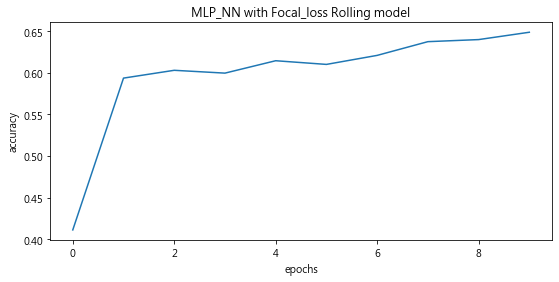

In [8]:
plt.figure(figsize=(9,4))
plt.title('MLP_NN with Focal_loss Rolling model')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(cv_accuracies)
plt.savefig('NNct')